### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

In [1]:
from fastai import *
from fastai.vision import *

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [ ]:
#folder = 'i10'
#file = 'download_i10.csv'

In [ ]:
#folder = 'i20'
#file = 'download_i20.csv'

You will need to run this line once per each category.

In [2]:
path = Path('data/cars')

In [ ]:
#dest = path/folder
#dest.mkdir(parents=True, exist_ok=True)

Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

![uploaded file](images/download_images/upload.png)

## Download images

Now you will need to download you images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename and the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [3]:
classes_cars = ['i10','i20']

In [ ]:
# download_images(path/file, dest, max_pics=200)

In [ ]:
# If you have problems download, try with `max_workers=0` to see exceptions:
# download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [ ]:
#for c in classes:
#    print(c)
#    verify_images(path/c, delete=True, max_workers=8)

## View data

In [ ]:
#np.random.seed(42)
#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
#        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [4]:
new_tfms = get_transforms()

In [5]:
data = (ImageItemList.from_folder(path)
        .random_split_by_pct(0.2)          
        .label_from_folder()
        .transform(tfms=new_tfms, size=224)
        .databunch()
        .normalize(imagenet_stats))

### Exporting the structure on the databunch. It will be helpful while making predictions on the individual images

In [6]:
data.export(fname='export.pkl')

In [ ]:
#np.random.seed(42)
#src = (ImageItemList.from_folder(path)
#        .random_split_by_pct(0.2)          
#        .label_from_folder())

In [ ]:
#data = (src.transform(tfms, size=224)
#        .databunch(bs=64).normalize(imagenet_stats))

Good! Let's take a look at some of our pictures then.

In [7]:
data.classes

['i10', 'i20']

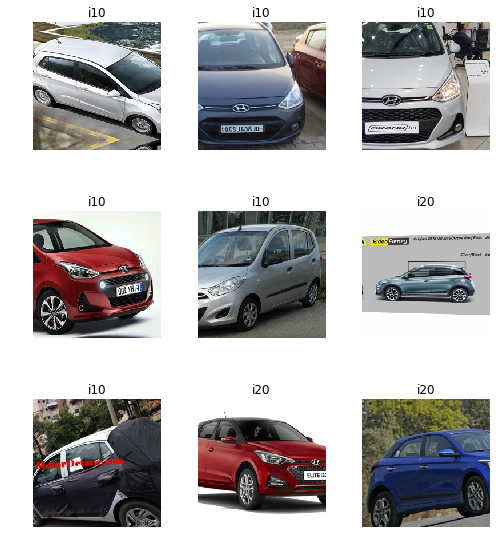

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['i10', 'i20'], 2, 307, 76)

## Train model

In [ ]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#m = Simplenet().to(device)

### Get resnet34 model for transfer learning

In [10]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

### Fit and check if model performs well

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.844765,0.599428,0.276316
2,0.750387,0.527280,0.328947
3,0.640364,0.517821,0.289474
4,0.591624,0.508443,0.289474


In [12]:
learn.save('stage-1')

### Unfreeze the last layers as we need to train well

In [13]:
learn.unfreeze()

### Find optimal learning rate & get the plot

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


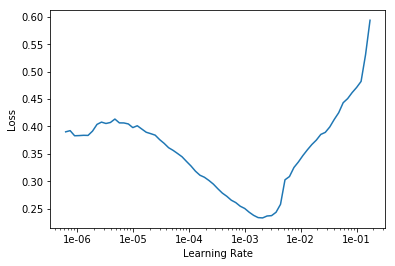

In [15]:
learn.recorder.plot()

### Fit the model again to get better predictions

In [16]:
learn.fit_one_cycle(10, max_lr=slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate
1,0.344841,0.438815,0.210526
2,0.324348,0.332353,0.105263
3,0.242338,0.414324,0.197368
4,0.210866,0.404845,0.092105
5,0.187182,0.411828,0.092105
6,0.163490,0.341963,0.065789
7,0.152727,0.242710,0.052632
8,0.137759,0.217560,0.052632
9,0.123338,0.202679,0.065789
10,0.108803,0.203498,0.092105


### Below command will save the model alongwith the weights. It can be used/loaded only when the system has "fastai" installed on the system, where we need to make the predictions on the individual images

In [17]:
learn.save('car_classifier')

### Below command will only save the weights. It can be used/loaded to make the predictions on the individual images using "pytorch". Dependency over fastai is not required.

In [18]:
torch.save(learn.model.state_dict(), 'cars.pth')

In [ ]:
#import dill
#torch.save(learn.model, 'new_img.pth', pickle_module=dill)

## Interpretation

In [19]:
learn.load('car_classifier');

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

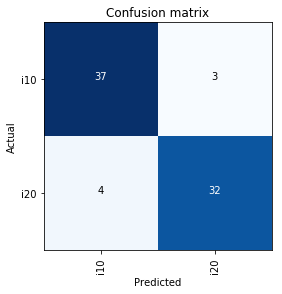

In [21]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be there.

Using the `FileDeleter` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [ ]:
#from fastai.widgets import *
#ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

Now we can pass in these paths to our widget.

In [ ]:
#fd = ImageDeleter(ds, idxs)

Flag photos for deletion by clicking 'Delete'. Then click 'Confirm' to delete flagged photos and keep the rest in that row. The `File_Deleter` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses`.

## Putting your model in production

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [22]:
import fastai
fastai.defaults.device = torch.device('cpu')

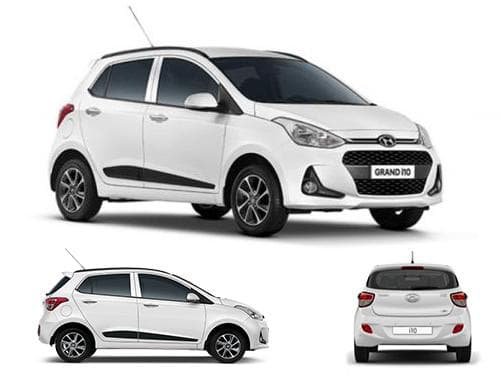

In [23]:
img = open_image(path/'i10'/'00000024.jpg')
img

In [24]:
classes_cars = ['i10', 'i20']

#### We need to make sure that the image uploaded for testing should be converted in the same format as we did for training dataset images

In [25]:
empty_data = ImageDataBunch.load_empty(path)

In [26]:
learn = create_cnn(empty_data, models.resnet34)

In [27]:
learn.load('car_classifier');

#### Our prediction is right in this case here, as it's a i10

In [28]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)

i10


- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs